In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tools import *
import operator
import itertools
torch.manual_seed(1)
np.random.seed(0)

In [2]:
train_data=torchvision.datasets.MNIST('./', train=True, download=True,transform=torchvision.transforms.ToTensor())
test_data=torchvision.datasets.MNIST('./', train=False, download=True,transform=torchvision.transforms.ToTensor())
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True)

In [3]:
train_data_list=[]
train_label_list=[]
for x,y in train_data:
    train_data_list.append(x)
    train_label_list.append(y)
    
test_data_list=[]
test_label_list=[]
for x,y in test_data:
    test_data_list.append(x)
    test_label_list.append(y)
    
train_data_tensor=torch.stack(train_data_list)
train_label_tensor=torch.tensor(train_label_list)
test_data_tensor=torch.stack(test_data_list)
test_label_tensor=torch.tensor(test_label_list)

print(train_data_tensor.size())
print(train_label_tensor.size())
print(test_data_tensor.size())
print(test_label_tensor.size())

torch.Size([60000, 1, 28, 28])
torch.Size([60000])
torch.Size([10000, 1, 28, 28])
torch.Size([10000])


In [4]:
class Net(nn.Module):
    def __init__(self,feature_dim):
        super(Net, self).__init__()
        self.feature_dim=feature_dim
        self.final_weight_dim=feature_dim*10
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 100)
        self.fc2 = nn.Linear(100, self.feature_dim)

        self.prior_mu=torch.tensor(np.zeros(200), dtype=torch.float, requires_grad=False)
        self.prior_diag=torch.tensor(np.ones(200), dtype=torch.float, requires_grad=False)
        
        self.q_mu=(torch.randn(200)*0.1).requires_grad_()
        self.q_diag=torch.tensor(np.ones(200), dtype=torch.float, requires_grad=True)
    
        params = list(self.parameters()) + [self.q_mu,self.q_diag]
        self.optimizer = optim.Adam(params, lr=0.0005)
        self.feature_optimizer = optim.Adam(self.parameters(), lr=0.001)
        self.final_optimizer = optim.Adam([ self.q_mu, self.q_diag ], lr=0.001)

    def forward(self, x, final_weight):
        x=x.view(-1,1,28,28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x =torch.tanh(self.fc2(x))
        x= torch.matmul(x,final_weight)
        return F.log_softmax(x,dim=-1)
    
    
    def feature_forward(self, x ):
        x=x.view(-1,1,28,28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x =  torch.tanh(self.fc2(x))
        return x
    
    def predict(self,x):
        with torch.no_grad():
            eps=torch.randn([100,self.final_weight_dim])
            ##100 10 70
            final_weight_samples=(torch.sqrt(self.q_diag).repeat(100).view(100,self.final_weight_dim)*eps+self.q_mu).view(100,self.feature_dim,10).permute(0, 2, 1)
            feature_of_data=self.feature_forward(x)
            
            prediction=(torch.mean(torch.softmax((inal_weight_samples@feature_of_data).permute(2, 0, 1),dim=-1),1).data.max(dim=1, keepdim=True)[1]).view(-1)
            return prediction
        
        
    def test(self,x,label):
        with torch.no_grad():
            eps=torch.randn([100,self.final_weight_dim])
            ##100 10 70
            final_weight_samples=(torch.sqrt(self.q_diag).repeat(100).view(100,self.final_weight_dim)*eps+self.q_mu).view(100,self.feature_dim,10).permute(0, 2, 1)
            feature_of_data=self.feature_forward(x)
#             print(final_weight_samples.size())
#             print(x.size())
#             print(feature_of_data.size())
            pred=(torch.mean(torch.softmax((final_weight_samples@feature_of_data.t()).permute(2, 0, 1),dim=-1),1).data.max(dim=1, keepdim=True)[1]).view(-1)
#             print(pred.size())
            accuracy=(pred == label).sum().item()/label.size(0)
            return accuracy

        

        
        
#     def predictive_distribution_entropy(self,x):
#         with torch.no_grad():
#             eps=torch.randn([100,self.final_weight_dim])
#             final_weight_samples=(torch.sqrt(self.q_diag).repeat(100).view(100,self.final_weight_dim)*eps+self.q_mu).view(100,self.feature_dim,10).permute(0, 2, 1)
#             feature_of_data=self.feature_forward(x)
#             #100,10,20*20,70
#             output_logit=final_weight_samples@feature_of_data.t()
#             output_dis=torch.distributions.categorical.Categorical(logits=output_logit)

#             sample=output_dis.sample([100]).reshape([-1,1])
#             entropy=-torch.mean(torch.log(torch.mean(torch.exp(output_dis.log_prob(sample)),dim=-1)))
#             return entropy
        
        
    def predictive_distribution_entropy_batch(self,x, sample_num=100):
        with torch.no_grad():
            eps=torch.randn([sample_num,self.final_weight_dim]) ### 100*200
            final_weight_samples=(torch.sqrt(self.q_diag).repeat(sample_num).view(sample_num,self.final_weight_dim)*eps+self.q_mu).view(sample_num,20,10).permute(0, 2, 1)
            feature_of_data=self.feature_forward(x)### 70*20

            output_logit=F.log_softmax((final_weight_samples@feature_of_data.t()).permute(2,0,1),dim=-1) ###70*100*10
#             output_dis=torch.distributions.categorical.Categorical(logits=output_logit)
            
            eps=torch.randn([sample_num,self.final_weight_dim])
            final_weight_samples=(torch.sqrt(self.q_diag).repeat(sample_num).view(sample_num,self.final_weight_dim)*eps+self.q_mu).view(sample_num,20,10).permute(0, 2, 1)
            feature_of_data=self.feature_forward(x)
            output_probs=F.softmax((final_weight_samples@feature_of_data.t()).permute(2,0,1),dim=-1) ###70*100*10
            output_dis_for_sample=sample_from_batch_categorical_multiple_cpu(output_logit,sample_num=30).view(x.size(0),-1) ### 70*100*30
            output_dis_for_sample_one_hot=one_hot_embedding(output_dis_for_sample, 10) ### 70*3000*10
#             print('output_dis_for_sample_one_hot',output_dis_for_sample_one_hot.size())
            output_probs=output_probs@output_dis_for_sample_one_hot.permute(0,2,1) ### 70*100*3000
#             print('output_probs',output_probs.size())
            entropy_list=-torch.mean(torch.log(torch.mean(output_probs,dim=1)),dim=-1)
#             print('entropy_list',entropy_list.size())
            return entropy_list



    
    def predictive_distribution_entropy_2(self,x, sample_num=100):
        with torch.no_grad():
            eps=torch.randn([sample_num,self.final_weight_dim])
            final_weight_samples=(torch.sqrt(self.q_diag).repeat(sample_num).view(sample_num,self.final_weight_dim)*eps+self.q_mu).view(sample_num,20,10).permute(0, 2, 1)
            feature_of_data=self.feature_forward(x)[0]

            output_logit=final_weight_samples@feature_of_data
            output_dis=torch.distributions.categorical.Categorical(logits=output_logit)

            eps=torch.randn([sample_num,self.final_weight_dim])
            final_weight_samples=(torch.sqrt(self.q_diag).repeat(sample_num).view(sample_num,self.final_weight_dim)*eps+self.q_mu).view(sample_num,20,10).permute(0, 2, 1)
            feature_of_data=self.feature_forward(x)[0]
            output_logit=F.log_softmax(final_weight_samples@feature_of_data,dim=-1)
            output_dis_for_sample=torch.distributions.categorical.Categorical(logits=output_logit)

            sample=output_dis_for_sample.sample([sample_num]).reshape([-1,1])
            entropy=-torch.mean(torch.log(torch.mean(torch.exp(output_dis.log_prob(sample)),dim=-1)))
            return entropy
        



        
        
    
    def train(self,x,label):
        train_losses = []
        if x.size(0)<100:
            batch_size=x.size(0)
            iteration=1
        else:
            batch_size=100
            iteration=int(x.size(0)/batch_size)
        for epoch in range(0,2000):
            for it in range(0,int(x.size(0)/batch_size)+1):
                index=np.random.choice(x.size(0),batch_size)
                self.optimizer.zero_grad()

    #             conditional_loss=0
    #             for i in range(0,10):
                eps=torch.randn([self.final_weight_dim])
                final_weight_sample= (self.q_mu+eps*torch.sqrt(self.q_diag)).view(self.feature_dim,10)
                output = self.forward(x[index],final_weight_sample)
                nll_loss= F.nll_loss(output,label[index],reduction='sum')*(float(x.size(0))/float(batch_size))
                kl=KL_diag_gaussian(self.q_mu,self.q_diag,self.prior_mu,self.prior_diag)
                neg_elbo=kl+nll_loss
                neg_elbo.backward()
                self.optimizer.step()
                train_losses.append(neg_elbo.item())
        plt.plot(train_losses)
        plt.show()
        

big_epoch: 0 start training...
train_data_size 10


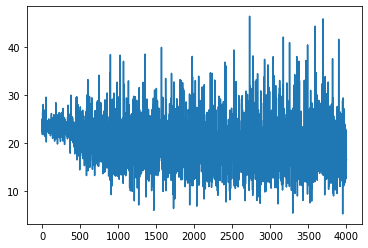

epoch: 0 test_accuracy 0.3046
big_epoch: 1 start training...
train_data_size 20


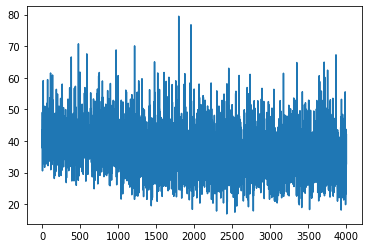

epoch: 1 test_accuracy 0.4021
big_epoch: 2 start training...
train_data_size 30


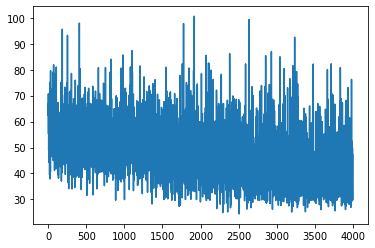

epoch: 2 test_accuracy 0.6112
big_epoch: 3 start training...
train_data_size 40


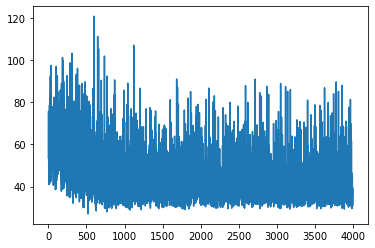

epoch: 3 test_accuracy 0.6484
big_epoch: 4 start training...
train_data_size 50


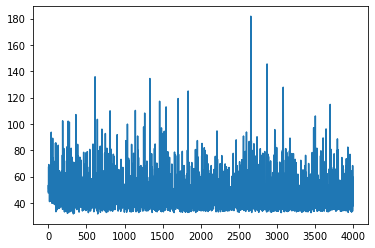

epoch: 4 test_accuracy 0.6995
big_epoch: 5 start training...
train_data_size 60


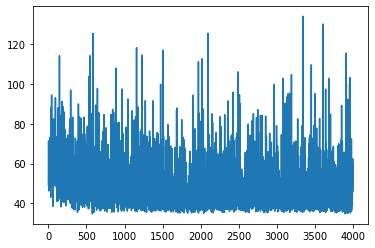

epoch: 5 test_accuracy 0.7586
big_epoch: 6 start training...
train_data_size 70


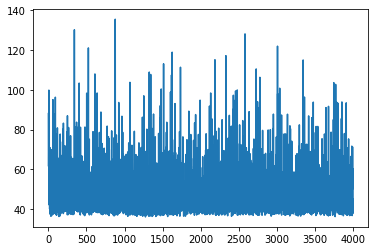

epoch: 6 test_accuracy 0.7704


In [ ]:
nn_tanh = Net(feature_dim=20)
init_train_data=train_data_tensor[0:10]
init_train_label=train_label_tensor[0:10]
accuracy_list=[]
for epoch in range(0,100):
    print('big_epoch:', epoch, 'start training...')
    print('train_data_size',init_train_label.size(0))
    nn_tanh.train(init_train_data,init_train_label)
    
    accuracy=nn_tanh.test(test_data_tensor,test_label_tensor)
    accuracy_list.append(accuracy)
    print('epoch:', epoch, 'test_accuracy', accuracy)

    for i in range(0,10):
        active_batch_data=train_data_tensor[i*6000:(i+1)*6000]
        entropy_list=nn_tanh.predictive_distribution_entropy_batch(active_batch_data,100)
#         print(entropy_list)
        _, index = entropy_list.max(0)
        init_train_data=torch.cat((init_train_data,active_batch_data[index].view(1,1,28,28)),0)
        init_train_label=torch.cat((init_train_label,train_label_tensor[index+i*6000].view(-1)),0)
        
        
plt.title('test_accuracy')
plt.plot(accuracy_list)
plt.show()
print(accuracy_list)

In [ ]:
# train_dict={}
# for (data, target) in train_data:
#     if  target not in train_dict:
#         train_dict[ target]=[]
#         train_dict[ target].append(data)
#     else:
#         train_dict[ target].append(data)
        
# initial_train_data=[]
# initial_train_label=[]
# for i in range(7):
#     for j in range(0,10):
#         initial_train_data.append(train_dict[i][j])
#         initial_train_label.append(i)
    
# print(initial_train_label)


# initial_train_data_tensor=torch.stack(initial_train_data)
# initial_train_label_tensor=torch.tensor(initial_train_label)
# train_x=torch.stack([data for (data, target) in train_data])
# train_label=torch.tensor([target for (data, target) in train_data])
# print(initial_train_data_tensor.size())
# print(initial_train_label_tensor.size())

In [ ]:
# active_bnn = Net(feature_dim=20).cuda()
# active_bnn.train(initial_train_data_tensor.cuda(),initial_train_label_tensor.cuda())

In [ ]:
# # print(active_bnn.test_prediction(initial_train_data_tensor))
# # # print(active_bnn.predict(initial_train_data_tensor))
# print(active_bnn.predictive_distribution_entropy_lower_bound(train_dict[6][20].cuda()))
# print(active_bnn.predictive_distribution_entropy_lower_bound(train_dict[8][20].cuda()))
# print(active_bnn.predictive_distribution_entropy_lower_bound(train_dict[8][21].cuda()))
# print(active_bnn.predictive_distribution_entropy_lower_bound(train_dict[1][20].cuda()))
# print(active_bnn.predictive_distribution_entropy_lower_bound(train_dict[1][1].cuda()))
# print(active_bnn.predictive_distribution_entropy_lower_bound(train_dict[0][1].cuda()))
# print(active_bnn.predictive_distribution_entropy_lower_bound(train_dict[4][1].cuda()))
# print(active_bnn.predictive_distribution_entropy_lower_bound(train_dict[4][16].cuda()))
# print(active_bnn.predictive_distribution_entropy_lower_bound(train_dict[4][15].cuda()))
# print('yo')
# # print(active_bnn.predictive_distribution_entropy(train_dict[6][20].cuda()))
# # print(active_bnn.predictive_distribution_entropy(train_dict[8][20].cuda()))
# # print(active_bnn.predictive_distribution_entropy(train_dict[8][21].cuda()))
# # print(active_bnn.predictive_distribution_entropy(train_dict[1][20].cuda()))
# # print(active_bnn.predictive_distribution_entropy(train_dict[1][1].cuda()))
# # print(active_bnn.predictive_distribution_entropy(train_dict[0][1].cuda()))
# # print(active_bnn.predictive_distribution_entropy(train_dict[4][1].cuda()))
# # print(active_bnn.predictive_distribution_entropy(train_dict[4][16].cuda()))
# # print(active_bnn.predictive_distribution_entropy(train_dict[4][15].cuda()))

# print('yo')
# print(active_bnn.predictive_distribution_entropy_2(train_dict[6][20].cuda()))
# print(active_bnn.predictive_distribution_entropy_2(train_dict[8][20].cuda()))
# print(active_bnn.predictive_distribution_entropy_2(train_dict[8][21].cuda()))
# print(active_bnn.predictive_distribution_entropy_2(train_dict[1][20].cuda()))
# print(active_bnn.predictive_distribution_entropy_2(train_dict[1][1].cuda()))
# print(active_bnn.predictive_distribution_entropy_2(train_dict[0][1].cuda()))
# print(active_bnn.predictive_distribution_entropy_2(train_dict[4][1].cuda()))
# print(active_bnn.predictive_distribution_entropy_2(train_dict[4][16].cuda()))
# print(active_bnn.predictive_distribution_entropy_2(train_dict[4][15].cuda()))
